In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib  as mpl
import matplotlib.pyplot as plt
import os, shutil, glob
from PIL import Image
from itertools import cycle
import re, math
import seaborn as sns; sns.set(color_codes=False)
os.getcwd()


'/Users/chririn/Documents/Code/Platemaps'

In [ ]:
from PIL import Image


In [2]:
Colors = [ 'darkorange', 'cornflowerblue',
                'forestgreen', 'red', 'yellow']
Alpha = 0.5 #transparency
LineWidth = 0.5

yRange = [-5.5, 6] # range for ploting scaled data (in SD)

FigureSize = (10, 5)
Resolution = 300
FontSize = 12
Flags = []

### Select one or several input files or folders

#### A) Folders

In [3]:
BaseDir = '/Users/chririn/Documents/ServerPortal/colo44/'
NameContains = '11'

InputFolders = glob.glob(BaseDir + '*' + NameContains + '*')
InputFolders

['/Users/chririn/Documents/ServerPortal/colo44/1171',
 '/Users/chririn/Documents/ServerPortal/colo44/1170',
 '/Users/chririn/Documents/ServerPortal/colo44/1175',
 '/Users/chririn/Documents/ServerPortal/colo44/1173']

In [4]:
# Take only the latest files
data =  pd.DataFrame()
ReadingFile = 0
for InpF in InputFolders:
    DataFromFolder =  pd.DataFrame()
    QC_files = glob.glob(InpF + '/**/qcRAW_images' + '*.csv', recursive=True)
    for file in QC_files[-1:]:
        print(file)
        DataFromOneFile =  pd.read_csv(file, sep=",", low_memory=False)
        ReadingFile += 1    
        DataFromFolder = pd.concat([DataFromFolder, DataFromOneFile.iloc[:,:]], ignore_index=True, sort=False)
        data = pd.concat([data, DataFromFolder.iloc[:,:]], ignore_index=True, sort=False)
print('Found %s files' %(ReadingFile))
print ('Dataframe contains %s columns and %s rows.' %(data.shape[1], data.shape[0]))

/Users/chririn/Documents/ServerPortal/colo44/1171/qcRAW_images_colo44-v1-FA-P017367-CACO2-48h-P2-L1.csv
/Users/chririn/Documents/ServerPortal/colo44/1170/qcRAW_images_colo44-v1-FA-P017365-CACO2-48h-P1-L1.csv
/Users/chririn/Documents/ServerPortal/colo44/1175/qcRAW_images_colo44-v1-FA-P017368-CACO2-48h-P2-L2.csv
/Users/chririn/Documents/ServerPortal/colo44/1173/qcRAW_images_colo44-v1-FA-P017366-CACO2-48h-P1-L2.csv
Found 4 files
Dataframe contains 587 columns and 11088 rows.


### Check number of plates, wells, sites

In [5]:
try: 
    PlateNames = sorted(list(set(data['Metadata_Barcode'])))
    print('Number of plates: %s' %(len(PlateNames)))
    print(PlateNames)
    data.sort_values(['Metadata_Barcode','Metadata_Well', 'Metadata_Site'], inplace = True)
    data.reset_index(drop=True, inplace = True)
except:
    print('Plate names not specified')
    PlateNames = []
Wells = sorted(list(set(data['Metadata_Well'])))
NrOfWells = len(Wells)
print('Number of wells: %s' %(NrOfWells))
Rows = sorted(list(set([w[0] for w in Wells])))
print(*Rows)
NrOfRows = len(Rows)
Columns = sorted(list(set([w[1:] for w in Wells])))
NrOfColumns = len(Columns)
print(*Columns)
Sites = sorted(list(set(data['Metadata_Site'])))
NrOfSites = len(Sites)
print('Number of sites: %s' %(NrOfSites))
print('Processed {} of {} images'.format(data.shape[0],len(PlateNames)*NrOfWells*NrOfSites))
# data.tail()

Number of plates: 4
['colo44-v1-FA-P017365-CACO2-48h-P1-L1', 'colo44-v1-FA-P017366-CACO2-48h-P1-L2', 'colo44-v1-FA-P017367-CACO2-48h-P2-L1', 'colo44-v1-FA-P017368-CACO2-48h-P2-L2']
Number of wells: 308
B C D E F G H I J K L M N O
02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23
Number of sites: 9
Processed 11088 of 11088 images


### Specify where to place plots

In [6]:
DatasetName = input("Enter name for output folder: ") # 3SD
PathToPlots = '/Users/chririn/Documents/Data/colo44/QC/' + DatasetName 
if not os.path.exists(PathToPlots): 
    os.makedirs(PathToPlots)

### Select measures

In [7]:
ImageQuality = [s for s in data.columns if "ImageQuality_" in s]
ImageQualityModule = [s.replace('ImageQuality_', '') for s in ImageQuality]
ImageQualityMeasures = sorted(list(set([re.sub('_.*', '', s) for s in ImageQualityModule])))
CountMeasures = len(ImageQualityMeasures)
print('ImageQuality module has measured '
      + str(CountMeasures) + ' parameters: ' + ', '.join(ImageQualityMeasures))

ImageQuality module has measured 22 parameters: Correlation, FocusScore, LocalFocusScore, MADIntensity, MaxIntensity, MeanIntensity, MedianIntensity, MinIntensity, PercentMaximal, PercentMinimal, PowerLogLogSlope, Scaling, StdIntensity, ThresholdBackground, ThresholdKapur, ThresholdMCT, ThresholdMoG, ThresholdOtsu, ThresholdRidlerCalvard, ThresholdRobustBackground, TotalArea, TotalIntensity


In [8]:
NotSoUseful = ['TotalArea', 'Scaling', 'TotalIntensity', 'Correlation', 'PercentMinimal'
               ,'LocalFocusScore', 'MinIntensity', 'MedianIntensity', 'MADIntensity'
               ,'ThresholdMoG'
               ,'ThresholdBackground'
               ,'ThresholdKapur'
               ,'ThresholdMCT'
               ,'ThresholdOtsu'
               ,'ThresholdRidlerCalvard'
               ,'ThresholdRobustBackground'
               , 'PercentMaximal'
               ]
for u in NotSoUseful:
    ImageQualityMeasures.remove(u)
CountMeasures = len(ImageQualityMeasures)
print('I will use ' + str(CountMeasures) + ' parameters: ' + 
      ', '.join(ImageQualityMeasures))



I will use 5 parameters: FocusScore, MaxIntensity, MeanIntensity, PowerLogLogSlope, StdIntensity


In [9]:
DataFrameDictionary = {}
for z in ImageQualityMeasures:
    parameter = [s for s in ImageQuality if ('_' + z) in s]
    DataFrameDictionary[z]=data[parameter]
DataFrameList = sorted(list(DataFrameDictionary.keys()))

### Create lineplots

In [10]:
nrSubplots=len(DataFrameList)
# old: ChannelNames = [ 'Hoechst', 'Mito', 'Phalloid.', 'Syto', 'Concan.']
# new:
ChannelNames = []
for c in list(DataFrameDictionary[DataFrameList[0]].columns):
    ChannelNames.append(re.sub('.*_', '', c))
ChannelNames

['CONC', 'HOECHST', 'MITO', 'PHAandWGA', 'SYTO']

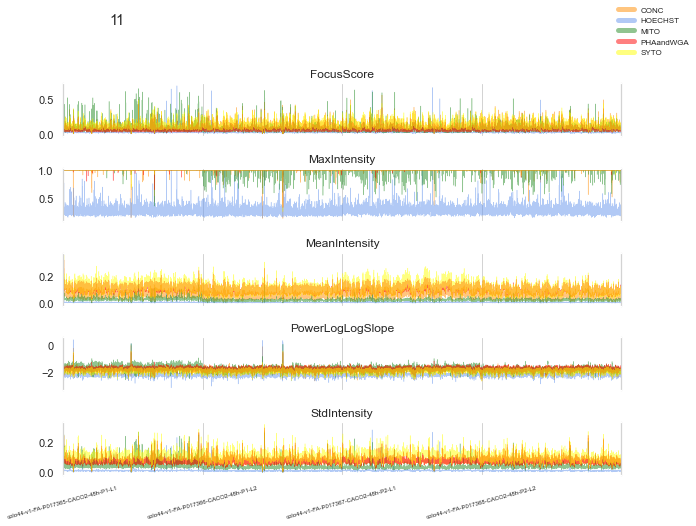

In [11]:
fig = plt.figure(figsize = (FigureSize[0],1.5*nrSubplots))
fig.suptitle(NameContains,fontsize = FontSize*1.2, x = 0.2)

for x in range(0, nrSubplots):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[x])
    CurrentDFName = ImageQualityMeasures[x]
    #print(CurrentDataFrame.columns)

    ax = fig.add_subplot(nrSubplots, 1, x+1)
    ax.set_title(CurrentDFName, fontsize = 12)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    ax.set_xlim([0, len(CurrentDataFrame.index)])
    #ax.set_ylim([0, 1])
    myplot = CurrentDataFrame.plot(kind='line', linewidth=0.5, alpha=Alpha, ax=ax, legend=None, color = Colors)
    xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns*NrOfRows)
    ax.set_xticks(xticks)
    # ax.set_yticks()
    ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=0)
    ax.tick_params(axis='x', labelbottom=False)
    if x == nrSubplots - 1:
        ax.tick_params(axis='x', labelbottom=True)
        ax.set_xticklabels(PlateNames)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(FontSize -6) 
            tick.label.set_rotation(15)
plt.subplots_adjust(top=0.85, hspace=0.60)
leg = fig.legend(ChannelNames, fontsize = 8, frameon=False)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig(PathToPlots + '/All.png', dpi=Resolution)
plt.show()

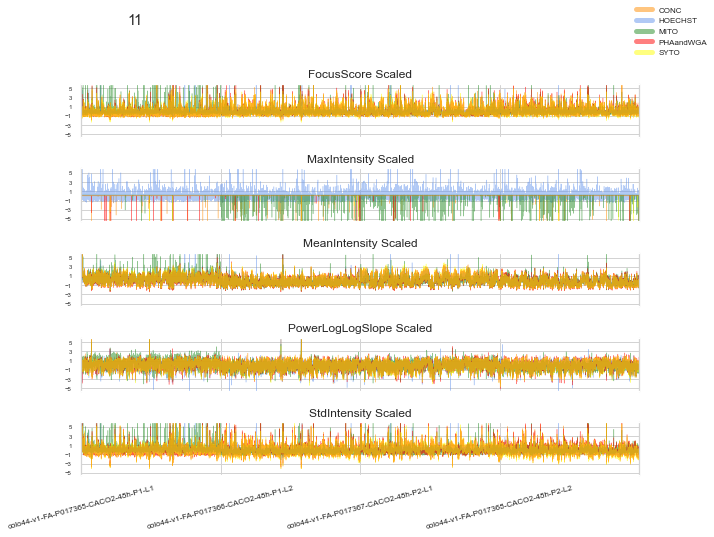

In [12]:
fig = plt.figure(figsize = (FigureSize[0],1.5*nrSubplots))
fig.suptitle(NameContains,fontsize = FontSize*1.2, x = 0.2)
for x in range(0, nrSubplots):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[x])
    CurrentDFName = ImageQualityMeasures[x]
    x_unscaled = CurrentDataFrame.values #returns a numpy array
    x_scaled = StandardScaler().fit_transform(x_unscaled)
    CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

    ax = fig.add_subplot(nrSubplots, 1, x+1)
    ax.set_title(CurrentDFName + ' Scaled', fontsize = FontSize)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    ax.set_xlim([0, len(CurrentDataFrameScaled.index)])
    ax.set_ylim(yRange[0], yRange[1])
    myplot = CurrentDataFrameScaled.plot(kind='line', linewidth=0.5, alpha=0.5, ax=ax, legend=None, color = Colors)
    xticks = np.arange(0, len(CurrentDataFrameScaled.index), NrOfSites*NrOfColumns*NrOfRows)
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(start = math.ceil(yRange[0]), stop = yRange[1], step = 2))
    ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.tick_params(axis='x', labelbottom=False)
    if x == nrSubplots - 1:
        ax.tick_params(axis='x', labelbottom=True)
        ax.set_xticklabels(PlateNames)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(FontSize -4) 
            tick.label.set_rotation(15)
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(6)
plt.subplots_adjust(top=0.85, hspace=0.60)
leg = fig.legend(ChannelNames, fontsize = 8, frameon=False)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig(PathToPlots + '/All_Scaled.png', dpi=Resolution)
plt.show()

### Create flags (for one measure at a time)

In [14]:
for i, item in enumerate(DataFrameList):
        print(i, item)

p = input('Enter an integer fro 0 to %s:' %(len(DataFrameList)-1))
try:
    p = int(p)
except:
    p=0
CurrentDataFrame = DataFrameDictionary.get(DataFrameList[p])
CurrentDFName = ImageQualityMeasures[p]
CurrentDataFrame.describe(percentiles =  [0.01, 0.05, 0.1, .25, .5, .75, .90, 0.95, .99]).iloc[1:]

0 FocusScore
1 MaxIntensity
2 MeanIntensity
3 PowerLogLogSlope
4 StdIntensity


,ImageQuality_StdIntensity_CONC,ImageQuality_StdIntensity_HOECHST,ImageQuality_StdIntensity_MITO,ImageQuality_StdIntensity_PHAandWGA,ImageQuality_StdIntensity_SYTO
mean,0.074308,0.013179,0.040974,0.078525,0.111264
std,0.017582,0.006965,0.017405,0.019012,0.025977
min,0.002095,0.001271,0.002620,0.005252,0.004295
1%,0.038414,0.006230,0.021501,0.042226,0.053705
5%,0.051182,0.008539,0.025256,0.055075,0.072502
10%,0.056132,0.009657,0.027609,0.059624,0.080856
25%,0.063915,0.011257,0.032093,0.066981,0.095184
50%,0.072789,0.012914,0.037821,0.076268,0.110575
75%,0.082625,0.014543,0.045345,0.086956,0.125942
90%,0.093349,0.016125,0.054281,0.098981,0.141019


#### Plot histograms for all quality measurements

In [ ]:
for ip in range(5):

    sns.set_style('darkgrid')
    A = DataFrameDictionary.get(DataFrameList[ip])
    sns.displot(A.iloc[1:]);
    #plt.axvline(x=0.22058956)

#### Plot Raw data

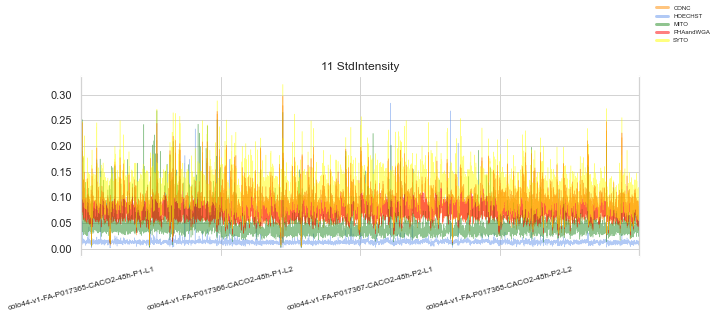

In [16]:
# PLOT RAW DATA

fig = plt.figure(figsize = FigureSize)
#fig.suptitle(' ',fontsize = FontSize, x=0.1)
ax = fig.add_subplot(111)
ax.set_title(NameContains + ' ' + CurrentDFName, fontsize = FontSize)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(CurrentDataFrame.index)])
ax.set_facecolor('w')
#ax.set_ylim([0, 0.2])
myplot = CurrentDataFrame.plot(kind='line', linewidth=LineWidth, alpha=Alpha, ax=ax, legend=None, color = Colors)
#ax.set_yticks([-2.3,  -0.5])
xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_xticklabels(PlateNames)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FontSize -4) 
    tick.label.set_rotation(15)
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1)
ax.tick_params(axis='x', labelbottom=True, color='lightgrey')
plt.subplots_adjust(top=0.8, bottom = 0.3, hspace=0.40)
leg = fig.legend(ChannelNames, fontsize = 6,frameon=False)
for line in leg.get_lines():
    line.set_linewidth(3.0)
plt.savefig(PathToPlots + '/' + CurrentDFName + '.png', dpi = Resolution)
plt.savefig(PathToPlots + '/' + CurrentDFName + '.pdf', dpi = Resolution)
plt.show() 

#### Plot Scaled data

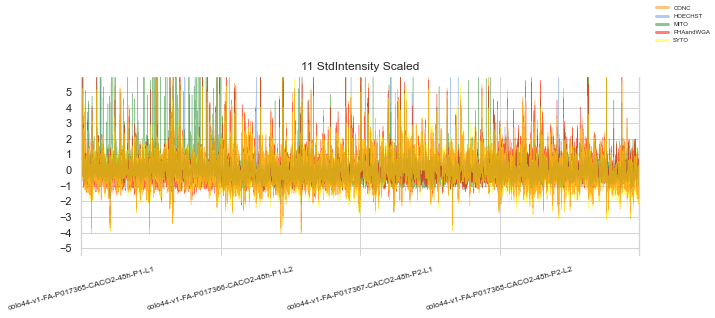

In [15]:
# PLOT SCALED DATA
x_unscaled = CurrentDataFrame.values 
x_scaled = StandardScaler().fit_transform(x_unscaled)
CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

fig = plt.figure(figsize = FigureSize)
ax = fig.add_subplot(111)
ax.set_title(NameContains + ' ' + CurrentDFName + ' Scaled', fontsize = FontSize)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(CurrentDataFrame.index)])

ax.set_facecolor('w')

myplot = CurrentDataFrameScaled.plot(kind='line', linewidth=LineWidth, alpha=Alpha, ax=ax, legend=None, color = Colors)
xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_xticklabels(PlateNames)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FontSize -4) 
    tick.label.set_rotation(15)
ax.set_ylim(yRange)
ax.set_yticks(np.arange(start = math.ceil(yRange[0]), stop = yRange[1]))
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.tick_params(axis='x', labelbottom=True, color='lightgrey')
plt.subplots_adjust(top=0.8, hspace=0.40, bottom = 0.3)
leg = fig.legend(ChannelNames, fontsize = 6,frameon=False)
for line in leg.get_lines():
    line.set_linewidth(3.0)
plt.savefig(PathToPlots + '/' +CurrentDFName + 'Scaled.png', dpi=Resolution)
plt.savefig(PathToPlots + '/' +CurrentDFName + 'Scaled.pdf', dpi=Resolution)
plt.show()

#### Save limits based on scaled data

In [17]:
LowerLimitScaled = float('-3.5') # e.g. -3 for MeanIntensityScaled
UpperLimitScaled = float('3.5')
NewFlagSc = 'OutlierScaled' + '_' + DataFrameList[p] + '_' + str(LowerLimitScaled) + '_' + str (UpperLimitScaled)
print('Outliers will be flagged in column: ' + NewFlagSc)
Flags.append(NewFlagSc)
data[NewFlagSc] = 0

Outliers will be flagged in column: OutlierScaled_StdIntensity_-3.5_3.5


,CONC,HOECHST,MITO,PHAandWGA,SYTO
mean,-2.281324e-16,3.588600e-17,4.331952e-16,5.626412e-16,1.230377e-16
std,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00
min,-4.107444e+00,-1.709845e+00,-2.203734e+00,-3.854337e+00,-4.117974e+00
1%,-2.041619e+00,-9.976985e-01,-1.118862e+00,-1.909396e+00,-2.215849e+00
5%,-1.315424e+00,-6.662238e-01,-9.030980e-01,-1.233528e+00,-1.492229e+00
10%,-1.033836e+00,-5.056308e-01,-7.679236e-01,-9.942492e-01,-1.170600e+00
25%,-5.911610e-01,-2.759840e-01,-5.102728e-01,-6.072307e-01,-6.190397e-01
50%,-8.639037e-02,-3.800320e-02,-1.811257e-01,-1.187459e-01,-2.654341e-02
75%,4.730967e-01,1.959197e-01,2.511692e-01,4.434811e-01,5.650356e-01
90%,1.083073e+00,4.230920e-01,7.646429e-01,1.076039e+00,1.145454e+00


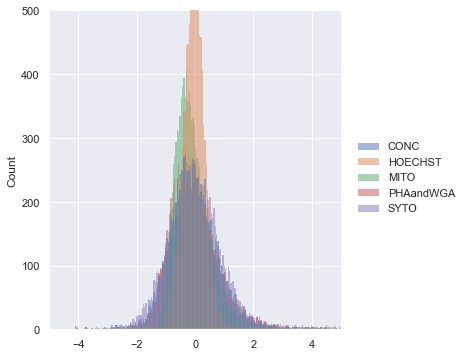

In [18]:
sns.set_style('darkgrid')
sns.displot(CurrentDataFrameScaled);
plt.xlim([-5, 5]); plt.ylim([0, 500]); 

CurrentDataFrameScaled.describe(percentiles =  [0.01, 0.05, 0.1, .25, .5, .75, .90, 0.95, .99]).iloc[1:]

In [19]:
CurrentDataFrameOutliersMetadata = data[(CurrentDataFrameScaled.values >= UpperLimitScaled).
                                any(1) | (CurrentDataFrameScaled.values <= LowerLimitScaled).
                                any(1)][['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site']]
CurrentDataFrameOutliersValues = CurrentDataFrameScaled[(CurrentDataFrameScaled.values >= UpperLimitScaled).
                                any(1) | (CurrentDataFrameScaled.values <= LowerLimitScaled).
                                any(1)]
CurrentDataFrameScaledOutliers = CurrentDataFrameOutliersMetadata.merge(CurrentDataFrameOutliersValues,
                                                                  left_index=True, right_index=True)
print(CurrentDataFrameScaledOutliers.shape[0])
CurrentDataFrameScaledOutliers

269


,Metadata_Barcode,Metadata_Well,Metadata_Site,CONC,HOECHST,MITO,PHAandWGA,SYTO
11,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B03,3,2.973304,0.996107,3.556092,4.352099,2.209626
12,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B03,4,1.109243,0.688156,1.506118,3.635914,1.676165
13,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B03,5,2.807034,1.057353,4.011206,3.727432,1.936593
14,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B03,6,2.530213,0.936930,4.571042,3.839051,1.949978
17,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B03,9,6.596465,5.765327,12.104786,8.802837,5.250829
...,...,...,...,...,...,...,...,...
10061,colo44-v1-FA-P017368-CACO2-48h-P2-L2,J19,9,7.264313,2.936511,6.993970,6.944634,4.740633
10079,colo44-v1-FA-P017368-CACO2-48h-P2-L2,J21,9,6.004950,2.526065,6.806126,5.539620,3.565492
10435,colo44-v1-FA-P017368-CACO2-48h-P2-L2,L17,5,8.847658,3.214573,9.515868,8.899099,6.232022
10581,colo44-v1-FA-P017368-CACO2-48h-P2-L2,M11,7,-0.923367,-0.707527,4.484503,2.673995,0.542597


In [ ]:
Outliers = CurrentDataFrameScaledOutliers.index.values.tolist()
data.loc[Outliers,NewFlagSc] = 1
print('%s images flagged in column %s' %(CurrentDataFrameScaledOutliers.shape[0], NewFlagSc))

#### Save all Flags

In [ ]:
data['Total'] = data[Flags].max(axis = 1)
Flags.append('Total')
print(data[Flags].sum())

In [ ]:
data[['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site', 'Count_nuclei'] + list(DataFrameDictionary[DataFrameList[3]].columns) + Flags].to_csv(PathToPlots + '/' + DatasetName + '_Flags.csv', sep = ';')

#### Save limits based on raw data

LowerLimit = -2.3 #float('-inf') # Here we can specify some limit; e.g. -2.3 for PowerLogLogSlope
UpperLimit = -0.5 #float('inf') e.g. -0.5 for PowerLogLogSlope
NewFlagRaw = 'Outlier' + '_' + DataFrameList[p] + '_' + str(LowerLimit) + '_' + str (UpperLimit)
Flags.append(NewFlagRaw)
print('Outliers will be flagged in column: ' + NewFlagRaw)
data[NewFlagRaw] = 0

CurrentDataFrameOutliersMetadata = data[(CurrentDataFrame.values > UpperLimit).
                                any(1) | (CurrentDataFrame.values < LowerLimit).
                                        any(1)][['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site']]
CurrentDataFrameOutliersValues = CurrentDataFrame[(CurrentDataFrame.values > UpperLimit).
                                any(1) | (CurrentDataFrame.values < LowerLimit).
                                any(1)]
CurrentDataFrameOutliers = CurrentDataFrameOutliersMetadata.merge(CurrentDataFrameOutliersValues,
                                                                  left_index=True, right_index=True)
print('%s images flagged in column %s' %(CurrentDataFrameOutliers.shape[0], NewFlagRaw))
CurrentDataFrameOutliers.head(50)

Outliers = CurrentDataFrameOutliers.index.values.tolist()
data.loc[Outliers,NewFlagRaw] = 1
print('%s images flagged in column %s' %(CurrentDataFrameOutliers.shape[0], NewFlagRaw))

#### Visualize flagged images

#for iImage in range(len(CurrentDataFrameScaledOutliers)):
for iImage in range(5):    
    ImF = glob.glob('/Volumes/mikro_pharmbio/ColoPaint/' + CurrentDataFrameScaledOutliers.Metadata_Barcode.iloc[iImage] + '/*/*/*' + CurrentDataFrameScaledOutliers.Metadata_Barcode.iloc[iImage] + '*' + CurrentDataFrameScaledOutliers.Metadata_Well.iloc[iImage] + '*s' + str(CurrentDataFrameScaledOutliers.Metadata_Site.iloc[iImage]) + '*_thumb*.tif');

    im = Image.open(ImF[0])
    im.show()

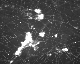

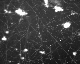

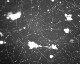

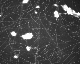

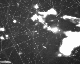

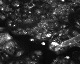

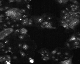

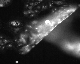

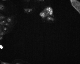

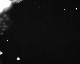

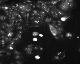

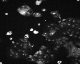

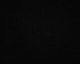

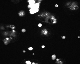

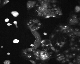

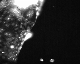

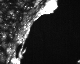

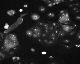

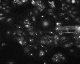

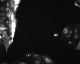

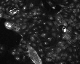

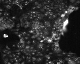

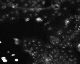

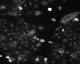

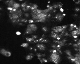

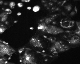

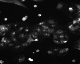

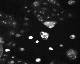

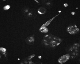

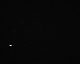

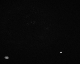

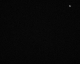

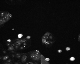

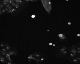

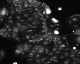

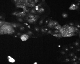

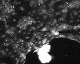

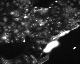

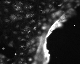

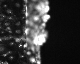

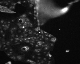

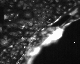

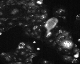

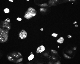

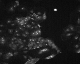

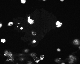

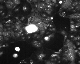

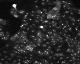

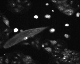

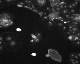

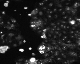

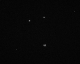

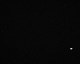

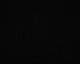

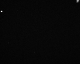

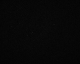

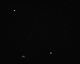

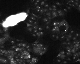

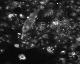

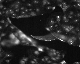

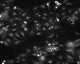

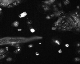

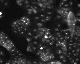

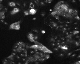

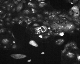

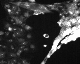

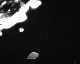

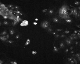

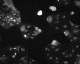

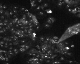

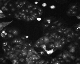

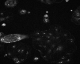

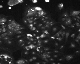

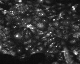

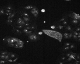

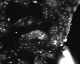

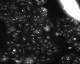

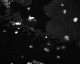

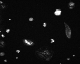

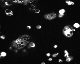

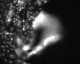

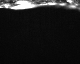

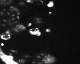

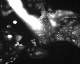

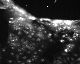

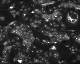

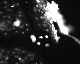

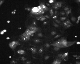

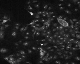

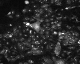

KeyboardInterrupt: 

In [59]:
for iImage in range(len(CurrentDataFrameScaledOutliers)):

    a = CurrentDataFrameScaledOutliers.Metadata_Barcode.iloc[iImage]
    b = CurrentDataFrameScaledOutliers.Metadata_Well.iloc[iImage]
    c = str(CurrentDataFrameScaledOutliers.Metadata_Site.iloc[iImage])

    ImF = [f for f in glob.glob('/Volumes/mikro_pharmbio/ColoPaint/' + a + '/*/*/*' + a + '*' + b + '*s' + c + '*_w4*.tif') if "_thumb" in f]

    im = Image.open(ImF[0])
    #im.show(title=a+'_'+b+'_'+c)
    display(im)

In [54]:
im.show(title=[a+'_'+b+'_'+c])

a+'_'+b+'_'+c


display(im2)

NameError: name 'im2' is not defined

a = CurrentDataFrameScaledOutliers.Metadata_Barcode.iloc[iImage]
b = CurrentDataFrameScaledOutliers.Metadata_Well.iloc[iImage]
c = str(CurrentDataFrameScaledOutliers.Metadata_Site.iloc[iImage])

ImF = [f for f in glob.glob('/Volumes/mikro_pharmbio/ColoPaint/' + a + '/*/*/*' + a + '*' + b + '*s' + c + '*_w3*.tif') if not "_thumb" in f]


ImF = glob.glob('/Volumes/mikro_pharmbio/ColoPaint/' + CurrentDataFrameScaledOutliers.Metadata_Barcode.iloc[0] + '/*/*/*' + CurrentDataFrameScaledOutliers.Metadata_Barcode.iloc[0] + '*' + CurrentDataFrameScaledOutliers.Metadata_Well.iloc[0] + '*s' + str(CurrentDataFrameScaledOutliers.Metadata_Site.iloc[0]) + '*_thumb*.tif');
print(ImF)

im1 = Image.open(ImF[3],mode='r');
im2 = Image.open(ImF[4],mode='r');
im2.show()


Image.merge('1',(im1,im2))


Image.blend(im1, im2, 0.5)
im1.show()

In [ ]:
#im = Image.open(ImF[4])
#imarray = np.array(im)
#imarray


#colormap = sns.color_palette("gray")
#fig = sns.heatmap(imarray, cmap=colormap)



## Heatmaps

#### Settings

In [ ]:
Co, Ro = 2, math.ceil(len(PlateNames)/2) # 
HeatmapSize = 12, 8
wspace = 0.3
hspace = 0.4
top = 0.75
names = data.columns

In [ ]:
def plot_heatmap(data, HeatmapFor,HeatmapSize,wspace,hspace, top, PlateNames):
    """this is a function to quickly plot the heatmaps per plate"""
    fig = plt.figure(figsize = (HeatmapSize))
    vmedall = math.ceil(data[HeatmapFor].quantile(0.5)*100)/100
    #vmin = math.floor(CurrentDataFrame[HeatmapFor].quantile(0.05)*100)/100


    fig.suptitle('{}'.format(HeatmapFor)  , fontsize = FontSize*1, y=0.8)
    n = 1
    for plate in PlateNames:
        dfoneplate = data.loc[data['Metadata_Barcode'] == plate][[HeatmapFor, 'Metadata_Well']]
        for x in Wells:
            if x not in dfoneplate['Metadata_Well']:
                # print (n)
                newline = pd.DataFrame([[0, x]], index = [0], columns = [HeatmapFor, 'Metadata_Well'])
                #print (newline)
                #print(dfoneplate)
                dfoneplate = pd.concat([dfoneplate, newline])
                #print(dfoneplate)
        #vmed = math.ceil(dfoneplate[HeatmapFor].quantile(0.5)*1000)/1000
        dictOfnumeric = { HeatmapFor : np.mean}
        groupedby = dfoneplate.groupby('Metadata_Well').agg(dictOfnumeric)
        vmed = math.ceil(groupedby[HeatmapFor].quantile(0.5)*1000)/1000
        v10 = math.ceil(groupedby[HeatmapFor].quantile(0.1)*1000)/1000
        v25 = math.ceil(groupedby[HeatmapFor].quantile(0.25)*1000)/1000
        v75 = math.ceil(groupedby[HeatmapFor].quantile(0.75)*1000)/1000
        # print(len(groupedby.index))
        if len(groupedby.index) > 0:
            #groupedbydf = pd.DataFrame(groupedby[HeatmapFor].values.reshape((NrOfRows,NrOfColumns)))
            groupedbyvalues = groupedby[HeatmapFor].values
            groupedbyvalues.resize(NrOfRows,NrOfColumns)
            groupedbydf = pd.DataFrame(groupedbyvalues)
            groupedbydf.columns = Columns
            groupedbydf.index = Rows
            # print('Maximum: ' + str(groupedbydf.to_numpy().max()))
            ax = fig.add_subplot(Ro, Co , n)
            ax = sns.heatmap(groupedbydf, vmin = 0,  
                                #cmap='RdBu_r',
                                cmap='Reds',
                                vmax = vmedall*2,
                                #vmax=200,
                                square = False,
                                linewidths = .5,
                                xticklabels = 1, yticklabels = groupedbydf.index,
                                #cbar_kws = {'ticks': [0, 50, 100, 150, 200, 250]}
                                )
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=7)
            plt.yticks(fontsize=FontSize/2.5,rotation=0)
            plt.xticks(fontsize=FontSize/2.5,rotation= -45) 

            ax.set_title(plate[:], fontsize = FontSize*0.7, loc= 'center')
            plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
            n += 1
            
    plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.png', dpi=Resolution, bbox_inches='tight')
    plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.pdf', dpi=Resolution, bbox_inches='tight')

In [ ]:
for item in names:
    try:
        HeatmapFor = item
        plot_heatmap(data, HeatmapFor,HeatmapSize,wspace,hspace, top, PlateNames)
        plt.close()
    except: 
        print('Could not plot the heatmap for: ', item)

#### Count nuclei

In [ ]:
fig = plt.figure(figsize = (HeatmapSize))
HeatmapFor = 'Count_nuclei'
    
vmedall = math.ceil(data[HeatmapFor].quantile(0.5)*100)/100
#vmin = math.floor(CurrentDataFrame[HeatmapFor].quantile(0.05)*100)/100


fig.suptitle('{}'.format(HeatmapFor)  , fontsize = FontSize*1, y=0.8)
n = 1
for plate in PlateNames:
    dfoneplate = data.loc[data['Metadata_Barcode'] == plate][[HeatmapFor, 'Metadata_Well']]
    for x in Wells:
        if x not in dfoneplate['Metadata_Well']:
            # print (n)
            newline = pd.DataFrame([[0, x]], index = [0], columns = [HeatmapFor, 'Metadata_Well'])
            #print (newline)
            #print(dfoneplate)
            dfoneplate = pd.concat([dfoneplate, newline])
            #print(dfoneplate)
    #vmed = math.ceil(dfoneplate[HeatmapFor].quantile(0.5)*1000)/1000
    dictOfnumeric = { HeatmapFor : np.mean}
    groupedby = dfoneplate.groupby('Metadata_Well').agg(dictOfnumeric)
    vmed = math.ceil(groupedby[HeatmapFor].quantile(0.5)*1000)/1000
    v10 = math.ceil(groupedby[HeatmapFor].quantile(0.1)*1000)/1000
    v25 = math.ceil(groupedby[HeatmapFor].quantile(0.25)*1000)/1000
    v75 = math.ceil(groupedby[HeatmapFor].quantile(0.75)*1000)/1000
    # print(len(groupedby.index))
    if len(groupedby.index) > 0:
        #groupedbydf = pd.DataFrame(groupedby[HeatmapFor].values.reshape((NrOfRows,NrOfColumns)))
        groupedbyvalues = groupedby[HeatmapFor].values
        groupedbyvalues.resize(NrOfRows,NrOfColumns)
        groupedbydf = pd.DataFrame(groupedbyvalues)
        groupedbydf.columns = Columns
        groupedbydf.index = Rows
        # print('Maximum: ' + str(groupedbydf.to_numpy().max()))
        ax = fig.add_subplot(Ro, Co , n)
        ax = sns.heatmap(groupedbydf, vmin = 0,  
                            #cmap='RdBu_r',
                            cmap='Reds',
                            vmax = vmedall*2,
                            #vmax=200,
                            square = False,
                            linewidths = .5,
                            xticklabels = 1, yticklabels = groupedbydf.index,
                            #cbar_kws = {'ticks': [0, 50, 100, 150, 200, 250]}
                            )
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=7)
        plt.yticks(fontsize=FontSize/2.5,rotation=0)
        plt.xticks(fontsize=FontSize/2.5,rotation= -45) 

        ax.set_title(plate[:], fontsize = FontSize*0.7, loc= 'center')
        plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
        n += 1
            
plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.png', dpi=Resolution, bbox_inches='tight')
plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.pdf', dpi=Resolution, bbox_inches='tight')

#### FocusScore Mito

In [ ]:
fig = plt.figure(figsize = (HeatmapSize))
HeatmapFor = 'ImageQuality_FocusScore_MITO'
    
vmedall = math.ceil(data[HeatmapFor].quantile(0.5)*100)/100
#vmin = math.floor(CurrentDataFrame[HeatmapFor].quantile(0.05)*100)/100


fig.suptitle('{}'.format(HeatmapFor)  , fontsize = FontSize*1, y=0.8)
n = 1
for plate in PlateNames:
    dfoneplate = data.loc[data['Metadata_Barcode'] == plate][[HeatmapFor, 'Metadata_Well']]
    for x in Wells:
        if x not in dfoneplate['Metadata_Well']:
            # print (n)
            newline = pd.DataFrame([[0, x]], index = [0], columns = [HeatmapFor, 'Metadata_Well'])
            #print (newline)
            #print(dfoneplate)
            dfoneplate = pd.concat([dfoneplate, newline])
            #print(dfoneplate)
    #vmed = math.ceil(dfoneplate[HeatmapFor].quantile(0.5)*1000)/1000
    dictOfnumeric = { HeatmapFor : np.mean}
    groupedby = dfoneplate.groupby('Metadata_Well').agg(dictOfnumeric)
    vmed = math.ceil(groupedby[HeatmapFor].quantile(0.5)*1000)/1000
    v10 = math.ceil(groupedby[HeatmapFor].quantile(0.1)*1000)/1000
    v25 = math.ceil(groupedby[HeatmapFor].quantile(0.25)*1000)/1000
    v75 = math.ceil(groupedby[HeatmapFor].quantile(0.75)*1000)/1000
    # print(len(groupedby.index))
    if len(groupedby.index) > 0:
        #groupedbydf = pd.DataFrame(groupedby[HeatmapFor].values.reshape((NrOfRows,NrOfColumns)))
        groupedbyvalues = groupedby[HeatmapFor].values
        groupedbyvalues.resize(NrOfRows,NrOfColumns)
        groupedbydf = pd.DataFrame(groupedbyvalues)
        groupedbydf.columns = Columns
        groupedbydf.index = Rows
        # print('Maximum: ' + str(groupedbydf.to_numpy().max()))
        ax = fig.add_subplot(Ro, Co , n)
        ax = sns.heatmap(groupedbydf, vmin = 0,  
                            #cmap='RdBu_r',
                            cmap='Reds',
                            vmax = vmedall*2,
                            #vmax=200,
                            square = False,
                            linewidths = .5,
                            xticklabels = 1, yticklabels = groupedbydf.index,
                            #cbar_kws = {'ticks': [0, 50, 100, 150, 200, 250]}
                            )
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=7)
        plt.yticks(fontsize=FontSize/2.5,rotation=0)
        plt.xticks(fontsize=FontSize/2.5,rotation= -45) 

        ax.set_title(plate[:], fontsize = FontSize*0.7, loc= 'center')
        plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
        n += 1
            
plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.png', dpi=Resolution, bbox_inches='tight')
plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.pdf', dpi=Resolution, bbox_inches='tight')

#### MeanIntensity CONC

In [ ]:
fig = plt.figure(figsize = (HeatmapSize))
HeatmapFor = 'ImageQuality_MeanIntensity_CONC'
    
vmedall = math.ceil(data[HeatmapFor].quantile(0.5)*100)/100
#vmin = math.floor(CurrentDataFrame[HeatmapFor].quantile(0.05)*100)/100


fig.suptitle('{}'.format(HeatmapFor)  , fontsize = FontSize*1, y=0.8)
n = 1
for plate in PlateNames:
    dfoneplate = data.loc[data['Metadata_Barcode'] == plate][[HeatmapFor, 'Metadata_Well']]
    for x in Wells:
        if x not in dfoneplate['Metadata_Well']:
            # print (n)
            newline = pd.DataFrame([[0, x]], index = [0], columns = [HeatmapFor, 'Metadata_Well'])
            #print (newline)
            #print(dfoneplate)
            dfoneplate = pd.concat([dfoneplate, newline])
            #print(dfoneplate)
    #vmed = math.ceil(dfoneplate[HeatmapFor].quantile(0.5)*1000)/1000
    dictOfnumeric = { HeatmapFor : np.mean}
    groupedby = dfoneplate.groupby('Metadata_Well').agg(dictOfnumeric)
    vmed = math.ceil(groupedby[HeatmapFor].quantile(0.5)*1000)/1000
    v10 = math.ceil(groupedby[HeatmapFor].quantile(0.1)*1000)/1000
    v25 = math.ceil(groupedby[HeatmapFor].quantile(0.25)*1000)/1000
    v75 = math.ceil(groupedby[HeatmapFor].quantile(0.75)*1000)/1000
    # print(len(groupedby.index))
    if len(groupedby.index) > 0:
        #groupedbydf = pd.DataFrame(groupedby[HeatmapFor].values.reshape((NrOfRows,NrOfColumns)))
        groupedbyvalues = groupedby[HeatmapFor].values
        groupedbyvalues.resize(NrOfRows,NrOfColumns)
        groupedbydf = pd.DataFrame(groupedbyvalues)
        groupedbydf.columns = Columns
        groupedbydf.index = Rows
        # print('Maximum: ' + str(groupedbydf.to_numpy().max()))
        ax = fig.add_subplot(Ro, Co , n)
        ax = sns.heatmap(groupedbydf, vmin = 0,  
                            #cmap='RdBu_r',
                            cmap='Reds',
                            vmax = vmedall*2,
                            #vmax=200,
                            square = False,
                            linewidths = .5,
                            xticklabels = 1, yticklabels = groupedbydf.index,
                            #cbar_kws = {'ticks': [0, 50, 100, 150, 200, 250]}
                            )
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=7)
        plt.yticks(fontsize=FontSize/2.5,rotation=0)
        plt.xticks(fontsize=FontSize/2.5,rotation= -45) 

        ax.set_title(plate[:], fontsize = FontSize*0.7, loc= 'center')
        plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
        n += 1
            
plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.png', dpi=Resolution, bbox_inches='tight')
plt.savefig(PathToPlots +  '/'+ HeatmapFor + '_heatmap.pdf', dpi=Resolution, bbox_inches='tight')

## PCA

In [ ]:
ColumnsToUse = []
Channel = 'all channels'
for c in ['ImageQuality_' + s for s in ImageQualityMeasures]:
    ColumnsToUse.extend([col for col in data.columns if c in col])
# print(ColumnsToUse)
data[ColumnsToUse].describe(percentiles =  [.25, .5, .75, .90, .99, .999]).iloc[1:]

In [ ]:
# USE ONLY ONE CHANNEL
# ColumnsToUse = []
# Channel = Channels[1]
# for c in ['ImageQuality_' + s for s in ImageQualityMeasures]:
#    ColumnsToUse.extend([col for col in data.columns if (c in col and Channel in col)])

In [ ]:
x = data.loc[:, ColumnsToUse].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2',
                                     'principal component 3', 'principal component 4'])
principalDf['plate'] = data['Metadata_Barcode']
loadingDf = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=ColumnsToUse)
#loadingDf.head()

In [ ]:
Means = np.array(principalDf.describe().iloc[1].values)
print(Means)
Stdevs = np.array(principalDf.describe().iloc[2].values)
print(Stdevs)
UpperLimits = Means + Stdevs*3
print(UpperLimits)
LowerLimits = Means - Stdevs*3
print(LowerLimits)


In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('PC1 for ' + Channel , fontsize = 15)
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(principalDf)])
#ax.set_ylim([0, len(principalDf)])
xticks = np.arange(0, len(principalDf.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_yticks([LowerLimits[0], 0, UpperLimits[0]])
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='g', linestyle='-', linewidth=1)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=True)
#ax.set_xlabel('PC 1', fontsize = 15)
#ax.set_ylabel('PC 2', fontsize = 15)
ax.scatter(principalDf.index, principalDf.loc[:, 'principal component 1'],
           marker = '.', s = 15);

plt.savefig(PathToPlots + '/' + Channel + '_PCA_1.png', dpi=Resolution)
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('PC2 for ' + Channel , fontsize = 15)
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(principalDf)])
#ax.set_ylim([0, len(principalDf)])
xticks = np.arange(0, len(principalDf.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_yticks([LowerLimits[1], 0, UpperLimits[1]])
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='g', linestyle='-', linewidth=1)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=True)
#ax.set_xlabel('PC 1', fontsize = 15)
#ax.set_ylabel('PC 2', fontsize = 15)
ax.scatter(principalDf.index, principalDf.loc[:, 'principal component 2'], marker = '.',
           s = 15);

plt.savefig(PathToPlots + '/' + Channel + '_PCA_2.png', dpi=Resolution)
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('PC3 for ' + Channel , fontsize = 15)
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(principalDf)])
#ax.set_ylim([0, len(principalDf)])
xticks = np.arange(0, len(principalDf.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_yticks([LowerLimits[1], 0, UpperLimits[1]])
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='g', linestyle='-', linewidth=1)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=True)
#ax.set_xlabel('PC 1', fontsize = 15)
#ax.set_ylabel('PC 2', fontsize = 15)
ax.scatter(principalDf.index, principalDf.loc[:, 'principal component 3'], marker = '.',
           s = 15);

plt.savefig(PathToPlots + '/' + Channel + '_PCA_3.png', dpi=Resolution)
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('PC1 and PC2 for ' + Channel , fontsize = 15)
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.set_xlim([-20, 20])
ax.set_ylim([-10, 10])
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=1)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
#ax.scatter(principalDf.loc[:, 'principal component 2'], principalDf.loc[:, 'principal component 3'],
#           marker = '.', s = 1);
targets = PlateNames

colors = ['lime']*10 # + ['cornflowerblue']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf['plate'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , alpha = 0.3
               , s = 5)

plt.savefig(PathToPlots + '/' + Channel + '_PCA_1_2.png', dpi=Resolution)
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('Loadings of PC1 and PC2 for ' + Channel , fontsize = 15)
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
#ax.set_xlim([0, len(principalDf)])
#ax.set_ylim([0, len(principalDf)])
#xticks = np.arange(0, len(principalDf.index), 540)
#ax.set_xticks(xticks)
#ax.set_yticks([LowerLimits[0], 0, UpperLimits[0]])
ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='', linewidth=1, alpha = 1)
ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=1)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
#ax.set_xlabel('PC 1', fontsize = 15)
#ax.set_ylabel('PC 2', fontsize = 15)
ax.scatter(loadingDf.loc[:, 'PC1'], loadingDf.loc[:, 'PC2'],
           marker = '.', s = 10);
for i, txt in enumerate(loadingDf.index):
    ax.annotate((txt[13:16] + '_' + txt[-4:]), (loadingDf.loc[txt, 'PC1'], loadingDf.loc[txt, 'PC2']))  

#plt.plot([0,100], [LowerLimits[0],LowerLimits[0]], color = 'r', linestyle='-')
#plt.plot([0,100], [UpperLimits[0],UpperLimits[0]], color = 'r', linestyle='-')
plt.savefig(PathToPlots + '/' + Channel + '_Loadings_PCA_1_2.png', dpi=Resolution)
plt.show()

In [ ]:
principalDf.reset_index(inplace = True)
principalDf.head()
PCs = data[['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site']].merge(principalDf,
                                                                       left_index=True, right_index=True)
PCs.to_csv(PathToPlots + '/PCA_1_4.csv', sep = ';')
PCs.head()

## Rest

### All other lineplots

In [ ]:
for x in range(0, len(DataFrameList)):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[x])
    CurrentDFName = ImageQualityMeasures[x]
    
    fig = plt.figure(figsize = FigureSize)
    #fig.suptitle(' ',fontsize = FontSize, x=0.1)
    ax = fig.add_subplot(111)
    ax.set_title(NameContains + ' ' + CurrentDFName, fontsize = FontSize)
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    ax.set_xlim([0, len(CurrentDataFrame.index)])
    ax.set_facecolor('w')
    #ax.set_ylim([0, 1])
    myplot = CurrentDataFrame.plot(kind='line', linewidth=LineWidth, alpha=Alpha, ax=ax, legend=None, color = Colors)
    xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns)
    ax.set_xticks(xticks)
    ax.set_xticklabels(Rows)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FontSize -2) 
        tick.label.set_rotation(45)
    ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=0)
    ax.tick_params(axis='x', labelbottom=True, color='lightgrey')
    plt.subplots_adjust(top=0.7, hspace=0.40)
    leg = fig.legend(ChannelNames, fontsize = FontSize,frameon=False)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    plt.savefig(PathToPlots + CurrentDFName + '.png', dpi = Resolution)
    plt.show()

# PLOT SCALED DATA
    x_unscaled = CurrentDataFrame.values 
    x_scaled = StandardScaler().fit_transform(x_unscaled)
    CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

    fig = plt.figure(figsize = FigureSize)
    ax = fig.add_subplot(111)
    ax.set_title(NameContains + ' ' + CurrentDFName + ' Scaled', fontsize = FontSize)
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    ax.set_xlim([0, len(CurrentDataFrame.index)])
    ax.set_facecolor('w')

    myplot = CurrentDataFrameScaled.plot(kind='line', linewidth=LineWidth, alpha=Alpha, ax=ax, legend=None, color = Colors)
    xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns)
    ax.set_xticks(xticks)
    ax.set_xticklabels(Rows)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FontSize -2) 
        tick.label.set_rotation(45)
    ax.set_ylim(yRange)
    ax.set_yticks(np.arange(start = math.ceil(yRange[0]), stop = yRange[1]))
    ax.grid(visible=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.grid(visible=True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.tick_params(axis='x', labelbottom=True, color='lightgreys')
    plt.subplots_adjust(top=0.7, hspace=0.40)
    leg = fig.legend(ChannelNames, fontsize = 12,frameon=False)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    # plt.savefig(PathToPlots + '/' + CurrentDFName + 'Scaled.png', dpi=Resolution)
    plt.show() 

### Flags automatically

In [ ]:
LowerLimitScaled = -3 #float('-inf') 
UpperLimitScaled = 3 #float('inf')

In [ ]:
for p in range(0, len(DataFrameList)):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[p])
    CurrentDFName = ImageQualityMeasures[p]
    
    x_unscaled = CurrentDataFrame.values 
    x_scaled = StandardScaler().fit_transform(x_unscaled)
    CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

    NewFlagSc = 'OutlierScaled' + '_' + DataFrameList[p] + '_' + str(LowerLimitScaled) + '_' + str (UpperLimitScaled)
    Flags.append(NewFlagSc)
    data[NewFlagSc] = 0

    CurrentDataFrameOutliersMetadata = data[(CurrentDataFrameScaled.values >= UpperLimitScaled).
                                    any(1) | (CurrentDataFrameScaled.values <= LowerLimitScaled).
                                    any(1)][['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site']]
    CurrentDataFrameOutliersValues = CurrentDataFrameScaled[(CurrentDataFrameScaled.values >= UpperLimitScaled).
                                    any(1) | (CurrentDataFrameScaled.values <= LowerLimitScaled).
                                    any(1)]
    CurrentDataFrameScaledOutliers = CurrentDataFrameOutliersMetadata.merge(CurrentDataFrameOutliersValues,
                                                                      left_index=True, right_index=True)

    Outliers = CurrentDataFrameScaledOutliers.index.values.tolist()
    data.loc[Outliers,NewFlagSc] = 1

In [ ]:
data['Total'] = data[Flags].max(axis = 1)
Flags.append('Total')
print(data[Flags].sum())

# data.to_csv(PathToPlots + '/' + 'Flagged.csv', sep = ';')

In [ ]:
data[['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site', 'Count_nuclei'] + list(DataFrameDictionary[DataFrameList[3]].columns) + Flags].to_csv(PathToPlots + '/' + DatasetName + '_Flags.csv', sep = ';')